In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from imblearn.over_sampling import SMOTE
from scipy.stats import chi2_contingency, ttest_ind
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier

In [2]:
data = pd.read_csv("term-deposit-marketing-2020.csv")
print("Data Loaded Successfully")

Data Loaded Successfully


In [7]:
# Generating summary statistics
summary_statistics = data.describe()
print("Summary Statistics:")
print(summary_statistics)

# Generating unique values for categorical data
unique_values = data.select_dtypes(include=['object']).nunique()
print("\nUnique Values in Categorical Columns:")
print(unique_values)

# Generating correlation matrix
correlation_matrix = data.corr()
print("\nCorrelation Matrix:")
print(correlation_matrix)

Summary Statistics:
                age        balance           day      duration      campaign
count  40000.000000   40000.000000  40000.000000  40000.000000  40000.000000
mean      40.544600    1274.277550     16.017225    254.824300      2.882175
std        9.641776    2903.769716      8.278127    259.366498      3.239051
min       19.000000   -8019.000000      1.000000      0.000000      1.000000
25%       33.000000      54.000000      8.000000    100.000000      1.000000
50%       39.000000     407.000000     17.000000    175.000000      2.000000
75%       48.000000    1319.000000     21.000000    313.000000      3.000000
max       95.000000  102127.000000     31.000000   4918.000000     63.000000

Unique Values in Categorical Columns:
job          12
marital       3
education     4
default       2
housing       2
loan          2
contact       3
month        11
y             2
dtype: int64

Correlation Matrix:
               age   balance       day  duration  campaign
age       1

C:\Users\aldhu\AppData\Local\Temp\ipykernel_32380\1887157847.py:12: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = data.corr()


In [9]:
# Data Quality Checks

# Checking for missing values in each column
missing_values = data.isnull().sum()
print("Missing Values in Each Column:")
print(missing_values)

# Checking for the total number of duplicate rows
duplicate_rows = data.duplicated().sum()
print("\nTotal Number of Duplicate Rows:")
print(duplicate_rows)

# Displaying data types of each column
data_types = data.dtypes
print("\nData Types of Each Column:")
print(data_types)

Missing Values in Each Column:
age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
y            0
dtype: int64

Total Number of Duplicate Rows:
0

Data Types of Each Column:
age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
y            object
dtype: object


In [12]:
# Class distribution analysis
class_counts = data['y'].value_counts()
minority_class = class_counts.idxmin()
majority_class = class_counts.idxmax()
print(class_counts)

no     37104
yes     2896
Name: y, dtype: int64


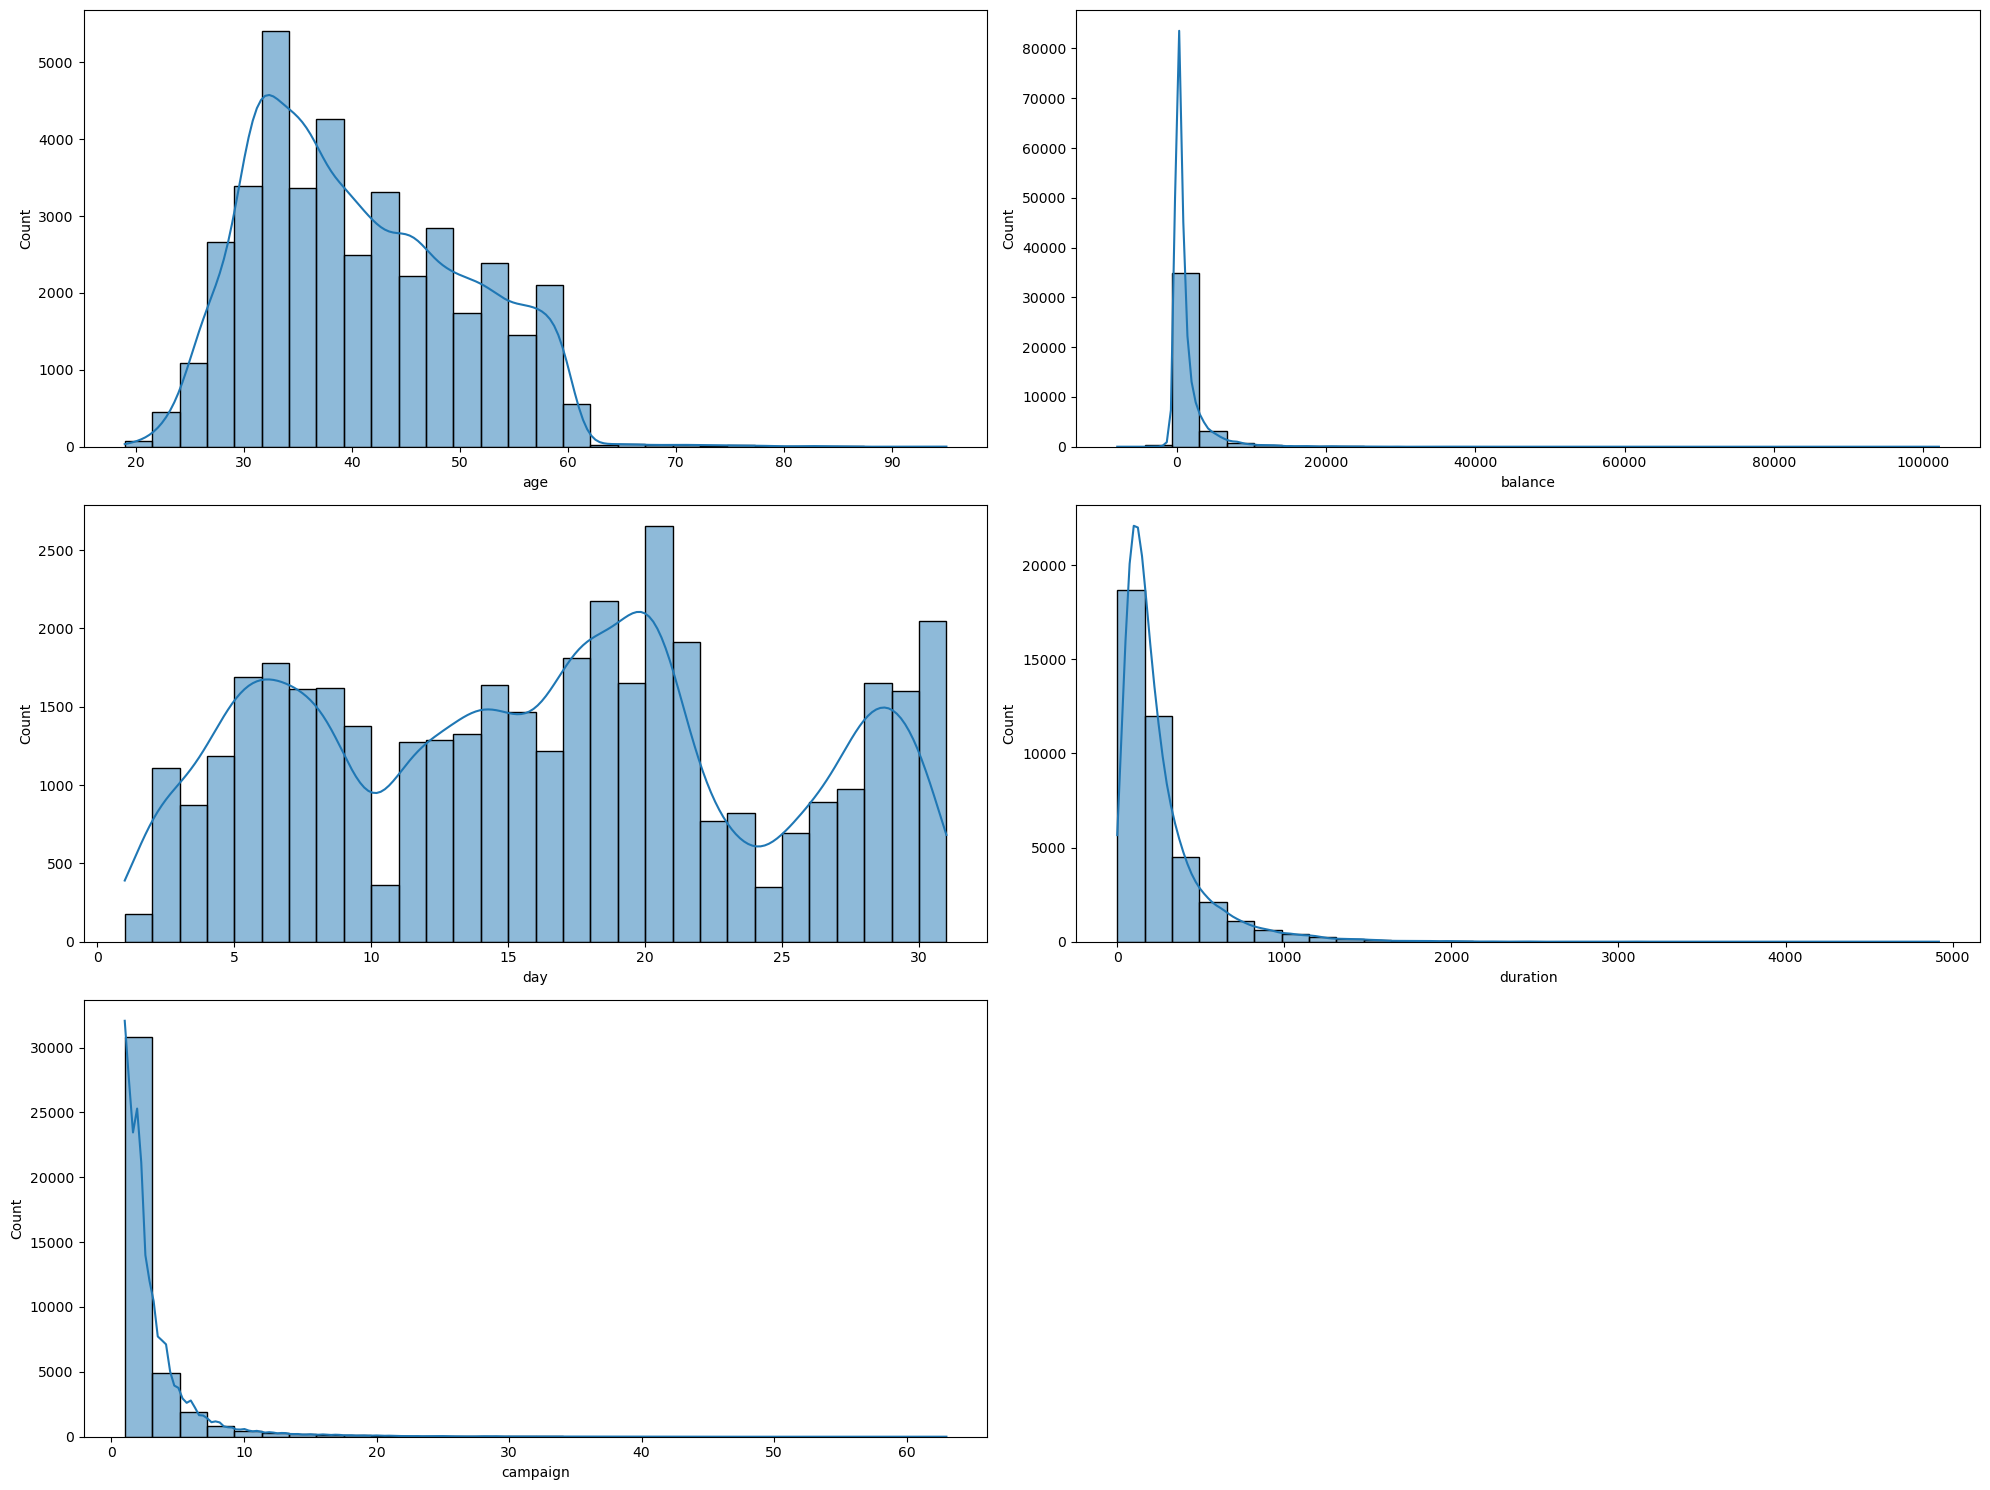

In [13]:
# Histograms for numerical columns
numerical_cols = ['age', 'balance', 'day', 'duration', 'campaign']
plt.figure(figsize=(20, 15))
for index, col in enumerate(numerical_cols):
    plt.subplot(3, 2, index + 1)
    sns.histplot(data[col], kde=True, bins=30)
plt.tight_layout()
plt.show()

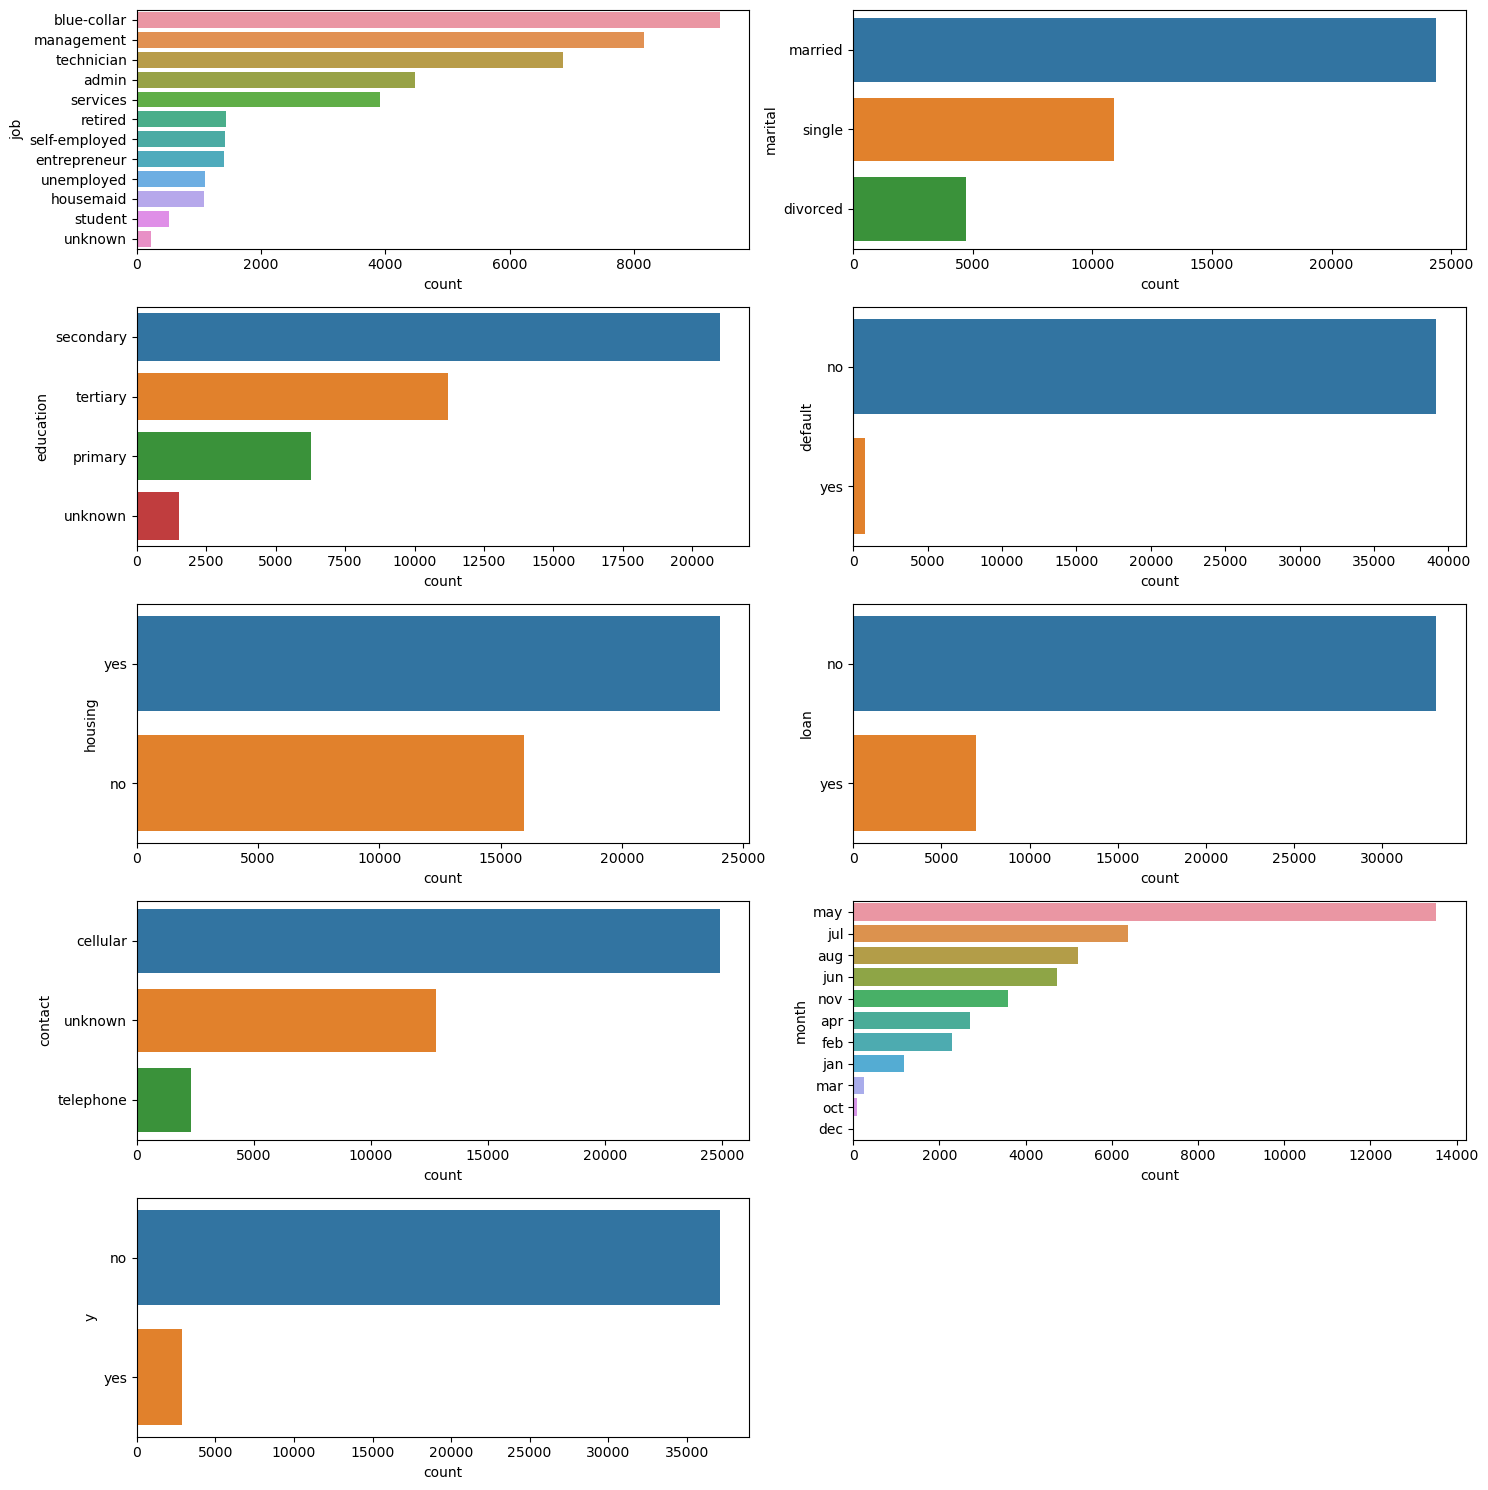

In [14]:
# Bar charts for categorical columns
categorical_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'y']
plt.figure(figsize=(15, 15))
for index, col in enumerate(categorical_cols):
    plt.subplot(5, 2, index + 1)
    sns.countplot(y=data[col], order=data[col].value_counts().index)
plt.tight_layout()
plt.show()

In [15]:
# Encoding Categorical Data
encoded_data = data.copy()
onehot_encoder = OneHotEncoder(sparse=False, drop='first')
label_encoder = LabelEncoder()
onehot_cols = ['job', 'marital', 'education', 'contact', 'month']
label_cols = ['default', 'housing', 'loan', 'y']

for col in onehot_cols:
    encoded_col = onehot_encoder.fit_transform(encoded_data[[col]])
    encoded_col_df = pd.DataFrame(encoded_col, columns=[f"{col}_{cat}" for cat in onehot_encoder.categories_[0][1:]])
    encoded_data = pd.concat([encoded_data.drop(col, axis=1), encoded_col_df], axis=1)

for col in label_cols:
    encoded_data[col] = label_encoder.fit_transform(encoded_data[col])

C:\Users\aldhu\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\aldhu\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\aldhu\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\aldhu\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. 

In [16]:
# Train-Test Split
X = encoded_data.drop('y', axis=1)
y = encoded_data['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
# Model Training and Evaluation
models = {
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

for model_name, model in models.items():
    # Cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5)
    print(f"{model_name} Model - CV Accuracy: {np.mean(cv_scores):.4f}")
    
    # Training and evaluation
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"Classification Report for {model_name}:")
    print(classification_report(y_test, y_pred))
    print(f"ROC-AUC Score for {model_name}: {roc_auc_score(y_test, y_pred):.4f}")
    print("=" * 50)

Decision Tree Model - CV Accuracy: 0.9111
Classification Report for Decision Tree:
              precision    recall  f1-score   support

           0       0.96      0.95      0.95      7424
           1       0.41      0.44      0.42       576

    accuracy                           0.91      8000
   macro avg       0.68      0.70      0.69      8000
weighted avg       0.92      0.91      0.91      8000

ROC-AUC Score for Decision Tree: 0.6955
Random Forest Model - CV Accuracy: 0.9338
Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.95      0.98      0.97      7424
           1       0.61      0.34      0.44       576

    accuracy                           0.94      8000
   macro avg       0.78      0.66      0.70      8000
weighted avg       0.93      0.94      0.93      8000

ROC-AUC Score for Random Forest: 0.6610
XGBoost Model - CV Accuracy: 0.9354
Classification Report for XGBoost:
              precision    re

In [18]:
# Apply SMOTE for balancing the classes
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Re-train models on balanced dataset
for model_name, model in models.items():
    model.fit(X_train_smote, y_train_smote)
    y_pred = model.predict(X_test)
    print(f"ROC-AUC Score for {model_name} (SMOTE): {roc_auc_score(y_test, y_pred):.4f}")
    print(f"F1 Score for {model_name} (SMOTE): {f1_score(y_test, y_pred):.4f}")
    print("=" * 50)

ROC-AUC Score for Decision Tree (SMOTE): 0.7077
F1 Score for Decision Tree (SMOTE): 0.4412
ROC-AUC Score for Random Forest (SMOTE): 0.6769
F1 Score for Random Forest (SMOTE): 0.4599
ROC-AUC Score for XGBoost (SMOTE): 0.7200
F1 Score for XGBoost (SMOTE): 0.5143


In [24]:
# Increase the weight of the minority class
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
minority_class = 1  
weights = {i: (class_weights[i] * 3 if i == minority_class else class_weights[i]) for i in range(len(class_weights))}

# Hyperparameter tuning 
dt_params = {
    'max_depth': [3, 5, 7, None],
    'min_samples_split': [2, 4, 6, 8],
    'min_samples_leaf': [1, 2, 3]
}
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5, 10],
}
xgb_params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
}

# Initialize models with adjusted class weights
models = {
    'Decision Tree': DecisionTreeClassifier(class_weight=weights),
    'Random Forest': RandomForestClassifier(class_weight=weights),
    'XGBoost': XGBClassifier(scale_pos_weight=weights[1], use_label_encoder=False, eval_metric='logloss')
}

# Perform hyperparameter tuning and evaluation
for model_name, model in models.items():
    if model_name == 'Decision Tree':
        search = GridSearchCV(model, dt_params, cv=5, scoring='accuracy')
    elif model_name == 'Random Forest':
        search = GridSearchCV(model, rf_params, cv=5, scoring='accuracy')
    elif model_name == 'XGBoost':
        search = RandomizedSearchCV(model, xgb_params, cv=5, scoring='accuracy', n_iter=10)

    search.fit(X_train, y_train)
    best_model = search.best_estimator_

    # Make predictions on the test set
    y_pred = best_model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"Model: {model_name}")
    print(f"Best Accuracy: {accuracy:.4f}")
    print(f"Best ROC-AUC Score: {roc_auc:.4f}")
    print(f"Best F1 Score: {f1:.4f}")
    print("=" * 50)
    
# Perform 5-fold cross-validation for average accuracy
print("\n" + "=" * 50)
print("Performing 5-Fold Cross-Validation for Average Accuracy")

best_models = {
    'Decision Tree': search.best_estimator_ if model_name == 'Decision Tree' else DecisionTreeClassifier(class_weight=weights),
    'Random Forest': search.best_estimator_ if model_name == 'Random Forest' else RandomForestClassifier(class_weight=weights),
    'XGBoost': search.best_estimator_ if model_name == 'XGBoost' else XGBClassifier(scale_pos_weight=weights[1], use_label_encoder=False, eval_metric='logloss')
}

for model_name, model in best_models.items():
    cv_accuracy_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    avg_accuracy = np.mean(cv_accuracy_scores)
    print(f"Average Accuracy (5-Fold CV) for {model_name}: {avg_accuracy:.4f}")

Model: Decision Tree
Best Accuracy: 0.9189
Best ROC-AUC Score: 0.6849
Best F1 Score: 0.4221
Model: Random Forest
Best Accuracy: 0.9343
Best ROC-AUC Score: 0.5971
Best F1 Score: 0.3079
Model: XGBoost
Best Accuracy: 0.8980
Best ROC-AUC Score: 0.8530
Best F1 Score: 0.5305

Performing 5-Fold Cross-Validation for Average Accuracy
Average Accuracy (5-Fold CV) for Decision Tree: 0.9176
Average Accuracy (5-Fold CV) for Random Forest: 0.9323
Average Accuracy (5-Fold CV) for XGBoost: 0.9035


### Best Overall Performance
XGBoost seems to be the best performer overall, particularly due to its superior ROC-AUC and F1 scores. These scores are crucial in scenarios where the ability to distinguish between classes and balance between precision and recall are more important than mere accuracy.

In [19]:
# Statistical Analysis
# T-test and Chi-square test
print("T-test Results for Numerical Features:\n")
for feature in numerical_cols:
    t_stat, p_val = ttest_ind(data[data['y'] == 'yes'][feature], data[data['y'] == 'no'][feature])
    print(f"{feature}: p-value = {p_val:.4f}")

print("\nChi-square Test Results for Categorical Features:\n")
for feature in categorical_cols[:-1]:  # Exclude target variable 'y'
    chi2, p_val, _, _ = chi2_contingency(pd.crosstab(data[feature], data['y']))
    print(f"{feature}: p-value = {p_val:.4f}")

T-test Results for Numerical Features:

age: p-value = 0.0001
balance: p-value = 0.0000
day: p-value = 0.1992
duration: p-value = 0.0000
campaign: p-value = 0.0000

Chi-square Test Results for Categorical Features:

job: p-value = 0.0000
marital: p-value = 0.0000
education: p-value = 0.0000
default: p-value = 0.2137
housing: p-value = 0.0000
loan: p-value = 0.0000
contact: p-value = 0.0000
month: p-value = 0.0000


## Statistical Analysis Insights

### T-test Results for Numerical Features:

- **age**: With a p-value of 0.0001, age is a critical factor in determining investment propensity, suggesting that different age groups may have varying financial priorities affecting their decision to invest.

- **balance**: The p-value of 0.0000 for balance confirms that customers with higher balances are more inclined to invest, likely reflecting greater financial resources or stability.

- **day**: A p-value of 0.1992 for day indicates no significant difference in the likelihood of investing based on the day of the month, suggesting it is not a key factor in the decision-making process.

- **duration**: The p-value of 0.0000 for call duration highlights its strong influence, implying that longer interactions on marketing calls may increase the likelihood of securing an investment.

- **campaign**: The significant p-value of 0.0000 for the number of contacts in a campaign suggests that the frequency and persistence of contact can be influential.

### Chi-square Test Results for Categorical Features:

- **job**: With a p-value of 0.0000, the job category is significant, implying the type of employment influences investment decisions.

- **marital**: Marital status, with a p-value of 0.0000, is a significant predictor, indicating different investment behaviors based on marital status.

- **education**: The significance of education, p-value at 0.0000, suggests that educational background affects the likelihood of purchasing an investment product.

- **default**: A p-value of 0.2137 for credit default indicates it's not a significant determinant in the decision to invest in the product.

- **housing**: Customers without housing loans, indicated by a p-value of 0.0000, show a higher propensity to invest, possibly due to lower financial liabilities.

- **loan**: Similarly, the absence of personal loans, with a p-value of 0.0000, correlates with a higher likelihood to invest.

- **contact**: The mode of contact has a significant p-value of 0.0000, emphasizing the importance of how customers are approached in marketing efforts.

- **month**: The p-value of 0.0000 for the month confirms that the timing of contact is a crucial factor in the success of marketing campaigns.

- **y**: As expected, the outcome variable shows a p-value of 0.0000, reinforcing its importance in the analysis.

In conclusion, these statistical tests suggest that financial stability (as evidenced by balance and absence of loans), demographic factors (such as age, job, marital status, and education), along with the quality and timing of marketing efforts (reflected by call duration, contact method, and month of contact), are all significant predictors of an individual's decision to invest in a term deposit.


C:\Users\aldhu\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


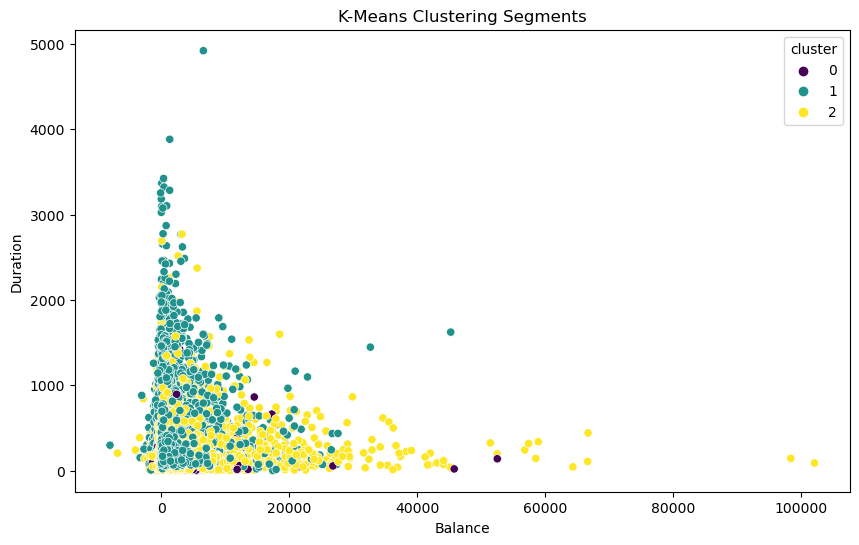

In [22]:
# Scaling the data for clustering
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data[numerical_cols])

# Applying K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(scaled_features)
data['cluster'] = clusters

# Visualizing clustering results
plt.figure(figsize=(10, 6))
sns.scatterplot(x='balance', y='duration', hue='cluster', data=data, palette='viridis')
plt.title('K-Means Clustering Segments')
plt.xlabel('Balance')
plt.ylabel('Duration')
plt.show()

## Segmentation and Feature Importance Insights

Leveraging the XGBoost feature importance and cluster analysis yields the following insights:

- **Cluster 0**: Customers with *moderate balance* and *lower call engagement*, often contacted *late in the month* with numerous campaign interactions.
- **Cluster 1**: Marked by *lower balances* yet *high call engagement*, these customers are typically contacted *early in the month*, suggesting a potential openness to investments.
- **Cluster 2**: Characterized by the *highest balances* and *moderate engagement*, with contact made *later in the month* but with *fewer interactions*, indicating a latent potential for investment.

**Marketing Focus**: Efforts should be concentrated on *Cluster 1* for their high engagement and *Cluster 2* for their financial readiness to invest.

**Conclusion**: Strategic emphasis on engagement metrics and financial readiness, as highlighted by XGBoost, can streamline targeting of customer groups most likely to invest.

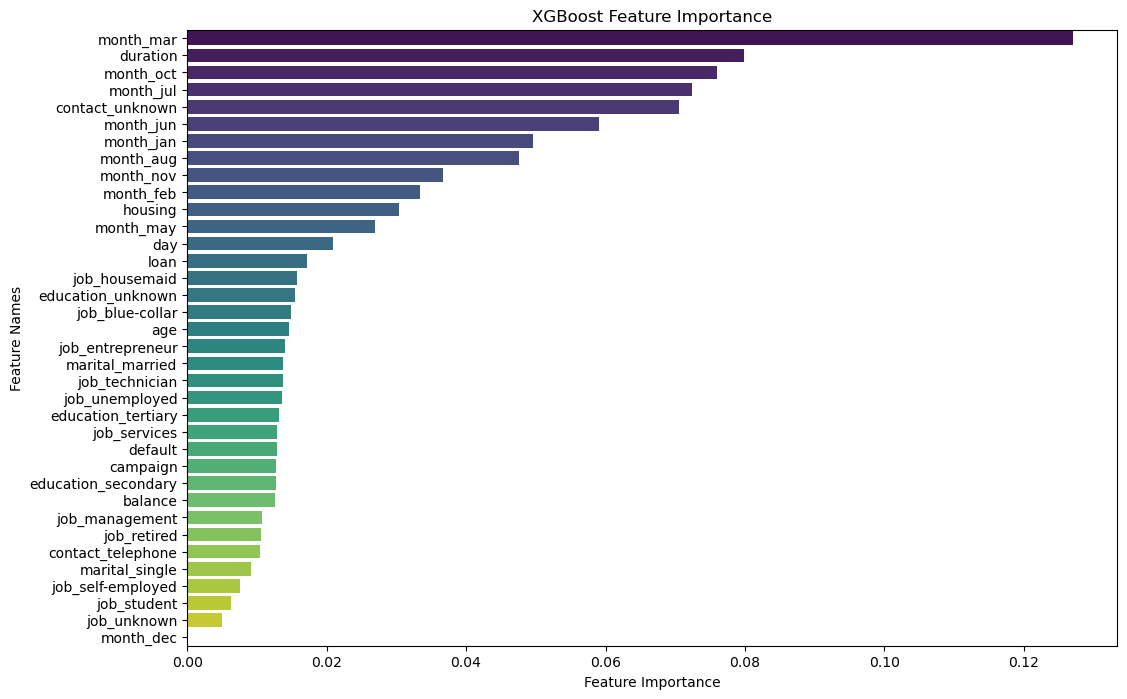

In [23]:
# Feature Importance Analysis (Using XGBoost)
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
feature_importances = xgb_model.feature_importances_
feature_names = X_train.columns
sorted_idx = feature_importances.argsort()[::-1]

plt.figure(figsize=(12, 8))
sns.barplot(x=feature_importances[sorted_idx], y=feature_names[sorted_idx], palette='viridis')
plt.title('XGBoost Feature Importance')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Names')
plt.show()

## Predictive Factors for Term Deposit Subscriptions

Analysis of the XGBoost model's feature importance yields insights into the determinants of term deposit subscriptions:

- **Timing Matters**: The impact of months (`month_mar`, `month_aug`, `month_jul`) suggests that the bank should align its marketing initiatives with these peak periods.

- **Call Quality**: The `duration` feature underscores the value of the call's length, implying that more in-depth conversations are beneficial.

- **Financial Indicators**: A higher `balance` and no `housing` loan commitment are strong predictors, hinting that financially healthier customers are more inclined to invest.

To sum up, optimizing marketing strategies to coincide with key months, ensuring substantive customer interactions, and focusing on financially stable customers could enhance subscription rates.